Avant image source
C-extension libroom unavailable. Falling back to pure python
Fin


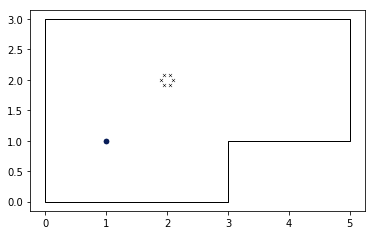

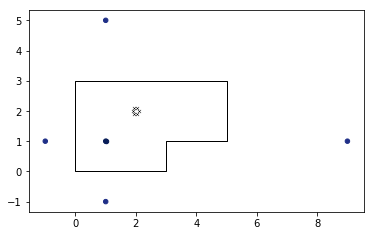

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import pyroomacoustics as pra

corners = np.array([[0,0], [0,3], [5,3], [5,1], [3,1], [3,0]]).T  # [x,y]
room = pra.Room.from_corners(corners, absorption=0.5, max_order=2)



# specify signal source
#fs, signal = wavfile.read("notebooks/arctic_a0010.wav")

# add source to 2D room
#room.add_source([1.,1.],signal=signal)
room.add_source([1.,1.])

#fig, ax = room.plot()


R = pra.circular_2D_array(center=[2.,2.], M=6, phi0=0, radius=0.1)
room.add_microphone_array(pra.MicrophoneArrayWithResponse(R, room.fs, 'lego1_h_theta_time.npy'))
#room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

fig, ax = room.plot()


print("Avant image source")
room.image_source_model(use_libroom=True)

fig, ax = room.plot(img_order=1)

print("Fin")
#print("Avant compute rir")
#room.compute_rir()
#print(len(room.rir))

#print("After")

#print(np.amax(np.array(room.rir[0][0])))
#print(np.array(room.rir))
#print(np.array(room.rir).shape)
#R = np.array([[3.5, 3.6], [2., 2.], [0.5,  0.5]])  # [[x], [y], [z]]
#print(pra.MicrophoneArray(R, room.fs).R.T)


Avant plot
Indeed with center
[225.         351.86989765 108.43494882 198.43494882 251.56505118
 261.86989765 225.         225.         315.         185.19442891
 353.65980825 135.          23.19859051 101.30993247]
112
Indeed with center
[225.         351.86989765 108.43494882 198.43494882 251.56505118
 261.86989765 225.         225.         315.         185.19442891
 353.65980825 135.          23.19859051 101.30993247]
112
Indeed with center
[225.         351.86989765 108.43494882 198.43494882 251.56505118
 261.86989765 225.         225.         315.         185.19442891
 353.65980825 135.          23.19859051 101.30993247]
112
Indeed with center
[225.         351.86989765 108.43494882 198.43494882 251.56505118
 261.86989765 225.         225.         315.         185.19442891
 353.65980825 135.          23.19859051 101.30993247]
112
Indeed with center
[225.         351.86989765 108.43494882 198.43494882 251.56505118
 261.86989765 225.         225.         315.         185.19442891
 3

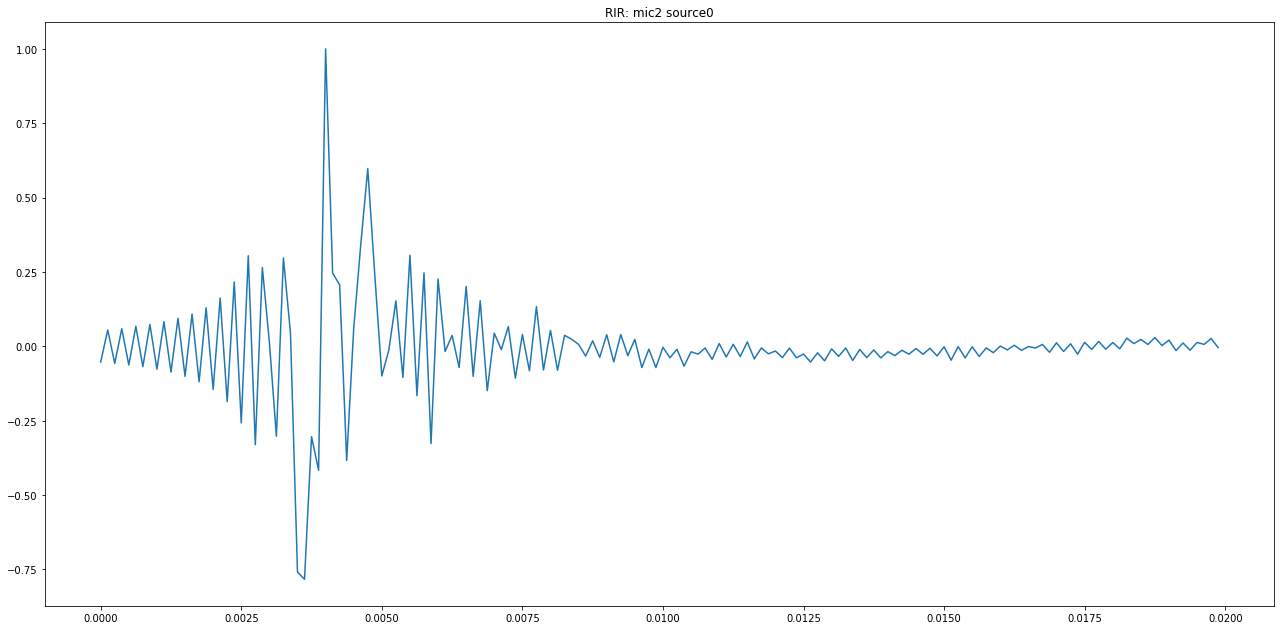

In [2]:
print("Avant plot")

room.plot_rir(select=2)


fig = plt.gcf()
fig.set_size_inches(20, 10)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import pyroomacoustics as pra
import math
import os
import datetime
import logging
import itertools
import seaborn as sns




# Taken from https://github.com/swing-research/scatsense/blob/master/core/signal.py 
# Code written by Dalia El Badawy with some small modifications
def calculate_angle_error(theta,theta_hat):
    '''Average localization error in degrees (modulo 360)
    Also finds the best permutation that gives the lowest error
    Input:
        theta: array of true indices
        theta_hat: array of estimated indices
        angles: list of angles in degrees
    '''
    J = len(theta) #number of sources
    all_perms = itertools.permutations(theta_hat) #all permutations
    min_err = np.Inf

    for beta in all_perms:
        curr_err = np.sum(np.absolute(((np.array(beta)-theta+180) % 360)-180))*1./J;
        if curr_err<min_err:
            min_err = curr_err
            perm = np.array(beta)
            
    return min_err,perm




L = 1  # number of sources
nfft = 1024  # FFT size

absorption = 1.
max_order = 0
snr_db = 5.    # signal-to-noise ratio

c = 343.    # speed of sound
fs = 16000  # sampling frequency
freq_range = [1, 8000]



values = [L, nfft, absorption, max_order]

outpath = os.path.join('PyroomAcousticsDataTestWithCenter',  '{0}source{1}frequencies{2}absorption{3}order'.format(*values))
if not os.path.exists(outpath):
    os.makedirs(outpath)

logfile = os.path.join(outpath, "log.txt")

logging.basicConfig(filename=logfile, format='%(asctime)s %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

dev = 'lego' # Change if using Kemar or lego
logger.info('Using transfer functions %s'%dev)

runs = 5

logger.info('freq range %s'%(freq_range))

logger.info('Number of runs %s'%(runs))
logger.info('Nfft %s'%(nfft))
logger.info('Noise in decibel %s'%(snr_db))
logger.info('Number of sources %s'%(L))
logger.info('Absorption of the walls %s'%(absorption))
logger.info('Max order (order of the echos) %s'%(max_order))


xPlot = 10 #runs/yplot
yPlot = 5 #runs/xplot


fig = plt.figure(figsize=(40,80))#give enough size to plot 50 subplots

conf_matrix = np.zeros((360, 360)) #confusion  matrix
#To keep the minimal error between each source at each run 
min_err_by_run = np.zeros(runs)

err_per_source = np.zeros((runs, L))

#radius = 37.5e-2 # #3rd
#radius = 7.5e-2 #2nd radius
#radius = 37.5e-3 #1st
#radius = 37.5e-4 #Small
#radius = 50e-2 #Test
radius = 10e-2 #seems to work the best

logger.info('Radius %s'%(radius))


for rns in range(runs):
    print(rns)

    # Location of sources
    # We only consider angles each 2 degrees because that's how our data is made and how we did it in the others
    # so better comparison possible
    Thetas = np.random.choice(range(180), L, replace=False)*2
    
    azimuth = Thetas / 180. * np.pi
    distance = 2.  # meters

    
    sigma2 = 10**(-snr_db / 10) / (4. * np.pi * distance)**2
    
    # Create a room


    #corners = np.array([[0,0], [0,9], [8,9], [8,4], [6,4], [6,0]]).T  # [x,y]
    #aroom = pra.Room.from_corners(corners, absorption=0.5)

    room_dim = np.r_[10.,10.]
    
    
    #aroom = pra.ShoeBox(room_dim, absorption=absorption, fs=fs, max_order=max_order, sigma2_awgn=sigma2)
    aroom = pra.ShoeBox(room_dim, absorption=absorption, fs=fs, max_order=max_order)    
    

    #R = pra.circular_2D_array(center=[2.,2.], M=6, phi0=0, radius=0.1)
    #aroom.add_microphone_array(pra.MicrophoneArrayWithResponse(R, aroom.fs, 'lego1_h_theta_time.npy'))

    #echo = pra.circular_2D_array(center=room_dim/2, M=6, phi0=0, radius=radius)
    #aroom.add_microphone_array(pra.MicrophoneArrayWithResponse(echo, aroom.fs, 'lego1_h_theta_time.npy'))
    #echo = pra.linear_2D_array(M=2, center=room_dim/2, d=0.18, phi=0)
    echo = np.array([[5.   ,5.  ],[4.91 ,5.09]])
    print(echo)
    aroom.add_microphone_array(pra.MicrophoneArrayWithResponse(echo, aroom.fs, 'kemar_h_theta_1deg_time.npy'))
    #aroom.add_microphone_array(pra.MicrophoneArray(echo, aroom.fs))


    # Add sources of 1 second duration
    rng = np.random.RandomState(23)
    duration_samples = int(fs)

    for ang in azimuth:
        source_location = room_dim / 2 + distance * np.r_[np.cos(ang), np.sin(ang)]
        source_signal = rng.randn(duration_samples) 
        aroom.add_source(source_location, signal=source_signal)

    #aroom.plot()
    #aroom.plot()

    # Run the simulation
    aroom.simulate()

    #aroom.plot_rir(select=0)

    #print(aroom.mic_array.signals[0].shape)

    X = np.array([pra.stft(signal, nfft, nfft // 2, transform=np.fft.rfft).T for signal in aroom.mic_array.signals])

    #print(X.shape)


    algo_names = ['MUSIC']
    spatial_resp = dict()

    # Construct the new DOA object
    # the max_four parameter is necessary for FRIDA only
    doa = pra.doa.algorithms['MUSIC'](echo, fs, nfft, c=c, num_src=2, max_four=4)

    # this call here perform localization on the frames in X
    doa.locate_sources(X, freq_range=freq_range)

    spatial_resp['MUSIC'] = doa.grid.values

    # normalize   
    min_val = spatial_resp['MUSIC'].min()
    max_val = spatial_resp['MUSIC'].max()
    spatial_resp['MUSIC'] = (spatial_resp['MUSIC'] - min_val) / (max_val - min_val)



    # plotting param

    base = 1.
    height = 10.
    true_col = [0, 0, 0]

    c_dirty_img = np.r_[spatial_resp['MUSIC'], spatial_resp['MUSIC'][0]]
    
    pairIndexValue = []
    for doaAngle in doa.azimuth_recon:
        angle = int(math.degrees(doaAngle))
        print(angle)
        pairIndexValue.append((angle, c_dirty_img[angle]))
    
    estimationAngles = []    
    for estimateSource in range(L):
        bestValue = 0
        bestPair = pairIndexValue[0]
        bestAngle = 0
        for pair in pairIndexValue:
            angle, value = pair
            if value > bestValue:
                bestValue = value
                bestPair = pair
                bestAngle = angle
        pairIndexValue.remove(bestPair)
        estimationAngles.append(bestAngle)
        

    #min_err is the average error for this run (named min_err because it's the minimum error for the permutations)
    #calculate error between chosen and true directions
    min_err, best_perm = calculate_angle_error(Thetas, estimationAngles) 
    conf_matrix[Thetas, best_perm] += 1

    min_err_by_run[rns] = min_err

    for src_j in range(L): #error per source
        err_per_source[rns, src_j] = np.sum(np.absolute(((best_perm[src_j]-Thetas[src_j]+180) % 360)-180))

    logger.info('Test %s, Actual DoAs: %s, MUSIC DoAs: %s, err: %s'%(rns, Thetas, best_perm, min_err))



    phi_plt = doa.grid.azimuth
    for algo_name in algo_names:
        # plot
        ax = fig.add_subplot(xPlot, yPlot, rns+1, projection='polar')
        c_phi_plt = np.r_[phi_plt, phi_plt[0]]
        c_dirty_img = np.r_[spatial_resp[algo_name], spatial_resp[algo_name][0]]
        ax.plot(c_phi_plt, base + height * c_dirty_img, linewidth=3,
                alpha=0.55, linestyle='-',
                label="spatial spectrum")
        plt.title('run %s'%rns)

        # plot true loc
        for angle in azimuth:
            ax.plot([angle, angle], [base, base + height], linewidth=3, linestyle='--',
                color=true_col, alpha=0.6)
        K = len(azimuth)
        ax.scatter(azimuth, base + height*np.ones(K), c=np.tile(true_col,
                   (K, 1)), s=500, alpha=0.75, marker='*',
                   linewidths=0,
                   label='true locations')

        plt.legend()
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, framealpha=0.5,
                  scatterpoints=1, loc='center right', fontsize=16,
                  ncol=1, bbox_to_anchor=(1.6, 0.5),
                  handletextpad=.2, columnspacing=1.7, labelspacing=0.1)

        ax.set_xticks(np.linspace(0, 2 * np.pi, num=12, endpoint=False))
        ax.xaxis.set_label_coords(0.5, -0.11)
        ax.set_yticks(np.linspace(0, 1, 2))
        ax.xaxis.grid(b=True, color=[0.3, 0.3, 0.3], linestyle=':')
        ax.yaxis.grid(b=True, color=[0.3, 0.3, 0.3], linestyle='--')
        ax.set_ylim([0, 1.05 * (base + height)]);

logger.info('Err_per_source average: %s, median: %s, Min_err average: %s, median: %s'%(np.mean(err_per_source, axis=0), np.median(err_per_source, axis=0), np.mean(min_err_by_run, axis=0), np.median(min_err_by_run, axis=0)))
logger.info('Err_per_source max: %s, min: %s, Min_err max: %s, min: %s'%(np.max(err_per_source, axis=0), np.min(err_per_source, axis=0), np.max(min_err_by_run, axis=0), np.min(min_err_by_run, axis=0)))

plt.savefig(os.path.join(outpath, 'Music_PyroomAcoustics_{0}source{1}samples.png'.format(*values)))


sns.set_style("whitegrid")
sns.set(font_scale=1.5) 
cmap = "PuBu"

plt.figure()
hm = sns.heatmap(20*np.log10(conf_matrix+1e-80), cmap=cmap, xticklabels=False,  yticklabels=False)
plt.xlabel('Estimate')
plt.ylabel('True')
plt.plot
plt.savefig(os.path.join(outpath, 'Music_conf_matrix_{0}source{1}samples.png'.format(*values)))



0
[[5.   5.  ]
 [4.91 5.09]]
C-extension libroom unavailable. Falling back to pure python
Not with center
[220.02523919]
220
Not with center
[223.85939702]
224
342
198
1
[[5.   5.  ]
 [4.91 5.09]]
C-extension libroom unavailable. Falling back to pure python
Not with center
[340.43009875]
340
Not with center
[335.65038097]
336
342
198
2
[[5.   5.  ]
 [4.91 5.09]]
C-extension libroom unavailable. Falling back to pure python
Not with center
[189.45588708]
189
Not with center
[194.49700887]
194
321
219
3
[[5.   5.  ]
 [4.91 5.09]]
C-extension libroom unavailable. Falling back to pure python
Not with center
[141.96870574]
142
Not with center
[146.14157045]
146
162
18
4
[[5.   5.  ]
 [4.91 5.09]]
C-extension libroom unavailable. Falling back to pure python
Not with center
[173.43772845]
173
Not with center
[178.57838665]
179
309
230
